# Handwriting Digit Recognition
- Based on the article by Amitrajit Bose 
- (https://medium.com/@amitrajit_bose/handwritten-digit-mnist-pytorch-977b5338e627)
- This code uses the MNIST digit dataset that is avaialbe through Pytorch

### Necessary Imports

In [2]:
# Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#we import packages to visaulise the data
import matplotlib.pyplot as plt
from time import time
import os

# These are the packages for Pytorch and numpy
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
from torch import optim

### Download The Dataset & Define The Transforms
- We use the transforms package to normalise and convert the data into tensor 
- we pass this to the dataset. MNIST frunction 
- If the data is not alrready downloaded the MNIST frunction will do it
- We create test and traing data and load them using the DataLoader class

In [ ]:
# create directory to store data
my_dr = "\\MNIST\\"


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST(my_dr, download=True, train=True, transform=transform)
valset = datasets.MNIST(my_dr, download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

### Exploring The Data
We get the next image out for the training loader and look at its shape and size

In [3]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


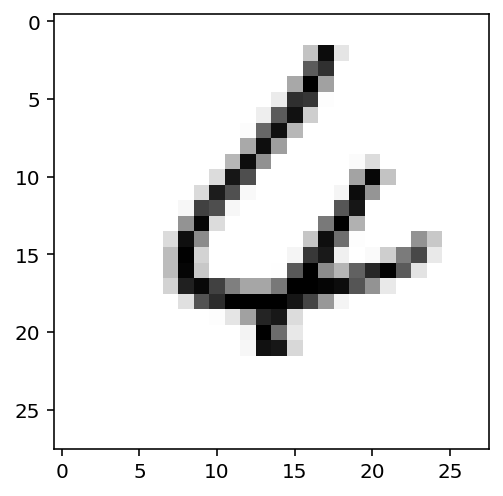

In [4]:
# We show the image to see what it looks like
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

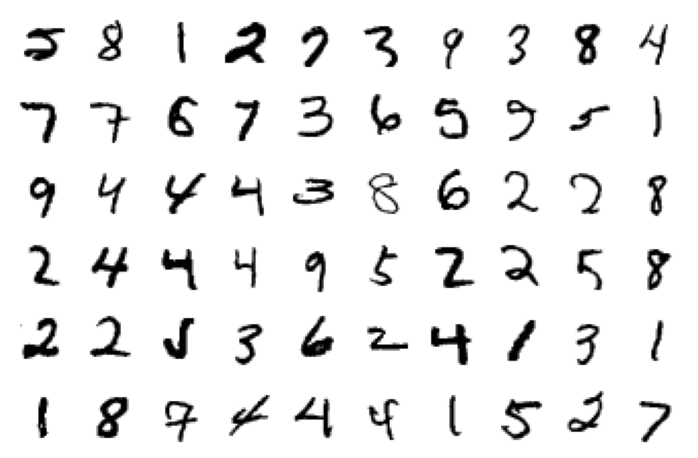

In [5]:
#we show 60 images to give an example of what we are training on
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### Defining The Neural Network
The picture below shows the Neural Network we will build

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

In [6]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### We define the network using torch.nn.Sequential
- The log softtmax function is the log of the softmax function 
- When used on conjuntion with nn.NLLLoss() function This has the same effect as Cross-entropy

In [7]:
# Layer details for the neural network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1)).to(device)

#Here we print out the network we just defined
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


### We define the loos function as The negative log likelihood loss. 
- It is useful to train a classification problem
- https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

In [8]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

### We print the weight before and after a backward
This helps us check that our network is working

In [9]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[0.0003, 0.0003, 0.0003,  ..., 0.0003, 0.0003, 0.0003],
        [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
        [0.0019, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0019],
        ...,
        [0.0012, 0.0012, 0.0012,  ..., 0.0012, 0.0012, 0.0012],
        [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0036],
        [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]])


In [ ]:
#the weights tell us the loss function is working

### We use Stochastic gradient descent as the optimiser
- You might want to try other optimsers to see how well they perform
- Try Adam https://arxiv.org/abs/1412.6980
- https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [24]:
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [25]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0327,  0.0298,  0.0128,  ..., -0.0308,  0.0329,  0.0289],
        [ 0.0048, -0.0290, -0.0026,  ..., -0.0136, -0.0339, -0.0026],
        [-0.0094, -0.0309, -0.0024,  ..., -0.0113,  0.0025, -0.0293],
        ...,
        [-0.0191,  0.0162,  0.0217,  ..., -0.0040,  0.0199,  0.0258],
        [-0.0145,  0.0335, -0.0196,  ..., -0.0069, -0.0315,  0.0173],
        [ 0.0135,  0.0135, -0.0021,  ..., -0.0165,  0.0140,  0.0128]],
       requires_grad=True)
Gradient - tensor([[ 2.7137e-03,  2.7137e-03,  2.7137e-03,  ...,  2.7137e-03,
          2.7137e-03,  2.7137e-03],
        [ 9.8191e-05,  9.8191e-05,  9.8191e-05,  ...,  9.8191e-05,
          9.8191e-05,  9.8191e-05],
        [-1.8160e-03, -1.8160e-03, -1.8160e-03,  ..., -1.8160e-03,
         -1.8160e-03, -1.8160e-03],
        ...,
        [-1.4149e-04, -1.4149e-04, -1.4149e-04,  ..., -1.4149e-04,
         -1.4149e-04, -1.4149e-04],
        [ 5.6838e-04,  5.6838e-04,  5.6838e-04,  ...,  5.6838e

In [26]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0327,  0.0297,  0.0128,  ..., -0.0308,  0.0329,  0.0288],
        [ 0.0048, -0.0290, -0.0026,  ..., -0.0136, -0.0339, -0.0026],
        [-0.0094, -0.0309, -0.0024,  ..., -0.0113,  0.0025, -0.0293],
        ...,
        [-0.0191,  0.0162,  0.0217,  ..., -0.0040,  0.0199,  0.0258],
        [-0.0145,  0.0335, -0.0196,  ..., -0.0069, -0.0315,  0.0173],
        [ 0.0135,  0.0135, -0.0021,  ..., -0.0165,  0.0140,  0.0128]],
       requires_grad=True)


### Core Training Of Neural Network
- The image is turned into one long 784 element vector. This is so the network can train on the images

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


Epoch 0 - Training loss: 0.6606427676705663
Epoch 1 - Training loss: 0.29061197540335565
Epoch 2 - Training loss: 0.2227457018652514
Epoch 3 - Training loss: 0.1775917939083186
Epoch 4 - Training loss: 0.14786947063648942
Epoch 5 - Training loss: 0.12690126224518267
Epoch 6 - Training loss: 0.11054418415728726
Epoch 7 - Training loss: 0.09847814964352926
Epoch 8 - Training loss: 0.08808840812195831
Epoch 9 - Training loss: 0.08100943399001477
Epoch 10 - Training loss: 0.0737675040345222
Epoch 11 - Training loss: 0.06703902557313537
Epoch 12 - Training loss: 0.061593299107089924
Epoch 13 - Training loss: 0.055514901176964775
Epoch 14 - Training loss: 0.05390970840869443

Training Time (in minutes) = 3.0190213521321616


### A function to show a classfied image to see if predicts correctly

In [14]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### Visually checking that the classfier is working

Predicted Digit = 9


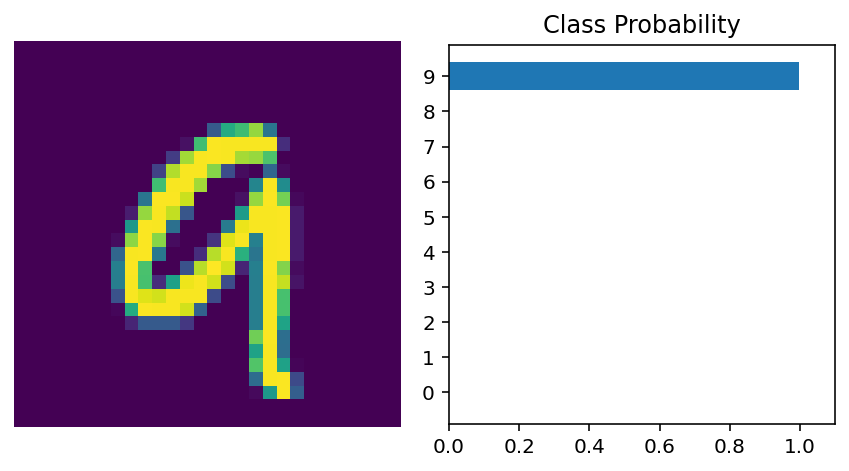

In [15]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

### Model Evaluation
We measure the percentage of correctly classifies images

In [16]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.969
